# Line-level text detection with Surya

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/openvinotoolkit/openvino_notebooks/blob/latest/notebooks/surya-line-level-text-detection/surya-line-level-text-detection.ipynb)

<div class="alert alert-block alert-danger"> <b>Important note:</b> This notebook requires python >= 3.9. Please make sure that your environment fulfill to this requirement  before running it </div>

In this tutorial we will perform line-level text detection using [Surya](https://github.com/VikParuchuri/surya) toolkit and OpenVINO.

![line-level text detection](https://github.com/VikParuchuri/surya/blob/master/static/images/excerpt.png?raw=true)

[**image source*](https://github.com/VikParuchuri/surya)


Model used for line-level text detection based on [Segformer](https://arxiv.org/pdf/2105.15203.pdf). It has the following features:
* It is specialized for document OCR. It will likely not work on photos or other images.
* It is for printed text, not handwriting.
* The model has trained itself to ignore advertisements.
* Languages with very different character sets may not work well.


#### Table of contents:

- [Fetch test image](#Fetch-test-image)
- [Run PyTorch inference](#Run-PyTorch-inference)
- [Convert model to OpenVINO Intermediate Representation (IR) format](#Convert-model-to-OpenVINO-Intermediate-Representation-(IR)-format)
- [Run OpenVINO model](#Run-OpenVINO-model)
- [Interactive inference](#Interactive-inference)



In [5]:
# %pip install -q --extra-index-url https://download.pytorch.org/whl/cpu  "transformers" "surya-ocr==0.1.6" "torch>=2.1" datasets gradio

## Fetch test image
[back to top ⬆️](#Table-of-contents:)

We will use an image from a randomly sampled subset of [DocLayNet](https://github.com/DS4SD/DocLayNet) dataset.

In [6]:
from datasets import load_dataset
import numpy as np
def fetch_image():
    dataset = load_dataset("vikp/doclaynet_bench", split="train", streaming=True)
    return next(iter(dataset))["image"]

test_image = fetch_image()

## Run PyTorch inference
[back to top ⬆️](#Table-of-contents:)

To perform line-level text detection we will use `load_model` and `load_processor` functions from `surya` package. We will also use `batch_inference` function which performs pre and post processing.

In [7]:
from surya.detection import batch_inference
from surya.model.segformer import load_model, load_processor

model, processor = load_model(), load_processor()

predictions = batch_inference([test_image], model, processor)
openvino_detection_result = predictions
openvino_boxes_arr = np.array(predictions[0]["bboxes"])

2024-04-09 23:13:26.088587: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512F AVX512_VNNI
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-09 23:13:26.235633: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


### Display the image

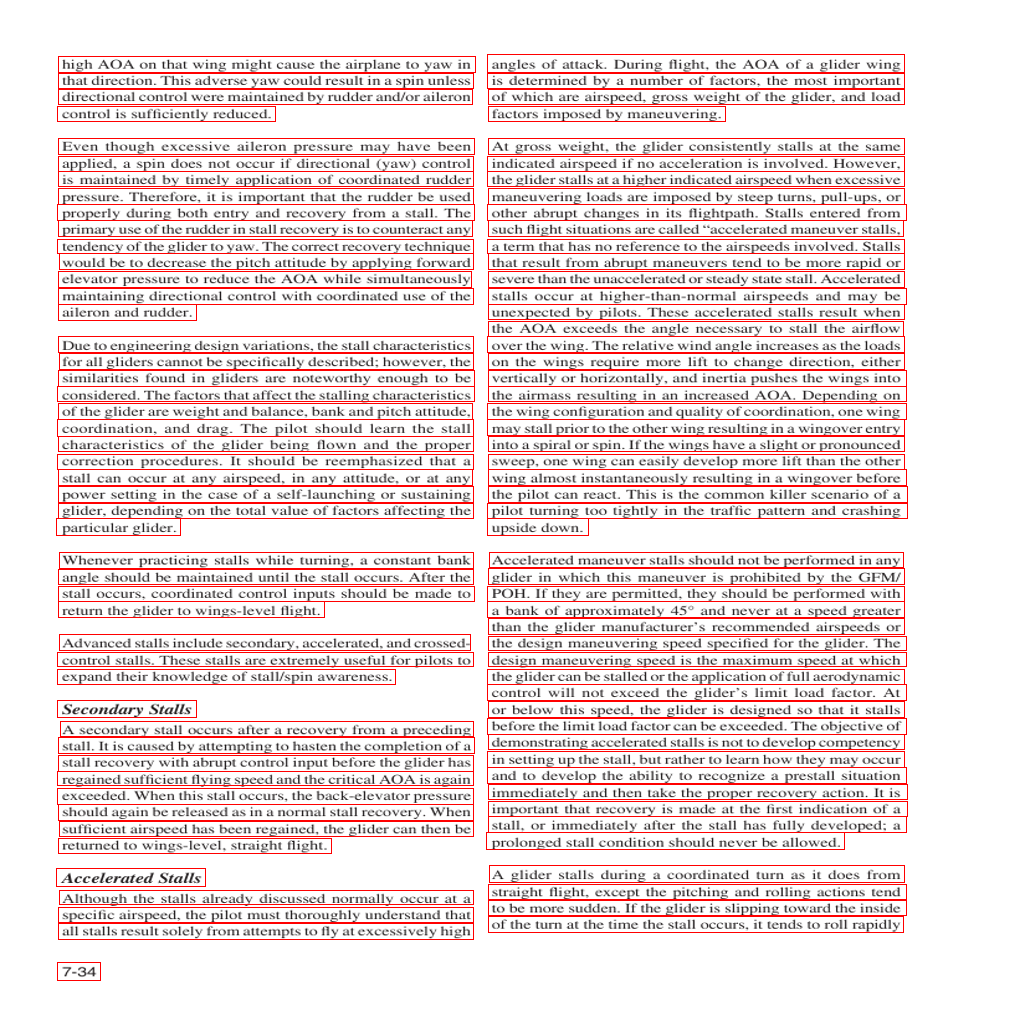

In [8]:
# Predictions visualization function
from PIL import ImageDraw

def visualize_prediction(image, prediction):
    image = image.copy()
    draw = ImageDraw.Draw(image)

    for bbox in prediction["bboxes"]:
        draw.rectangle(bbox, width=1, outline="red")

    display(image)

visualize_prediction(test_image, predictions[0])

## PySDK Version

In [9]:
# make sure PySDK and degirum-tools is installed
# !pip show degirum || pip install degirum
# !pip show degirum-tools || pip install degirum-tools

hw_location = "@local"
model_zoo_url = "https://cs.degirum.com/degirum/timm_gender_model_test"
model_name = "document_text_detection--896x896_float_openvino_cpu_1"
image_source = "https://raw.githubusercontent.com/DeGirum/PySDKExamples/features/images/text_document.jpg"

In [10]:
import degirum as dg, degirum_tools
from document_ocr_postprocessor import DocTextDetPostprocessor
# Connect to AI inference engine
# degirum_cloud_token: Degirum cloud API access token
document_text_det_zoo = dg.connect(hw_location, model_zoo_url, degirum_tools.get_token())

In [11]:
document_text_det_model = document_text_det_zoo.load_model(model_name, input_image_format="RAW", custom_postprocessor = DocTextDetPostprocessor, overlay_show_labels = False)
document_text_det_model.image_backend="pil"
res = document_text_det_model(image_source)

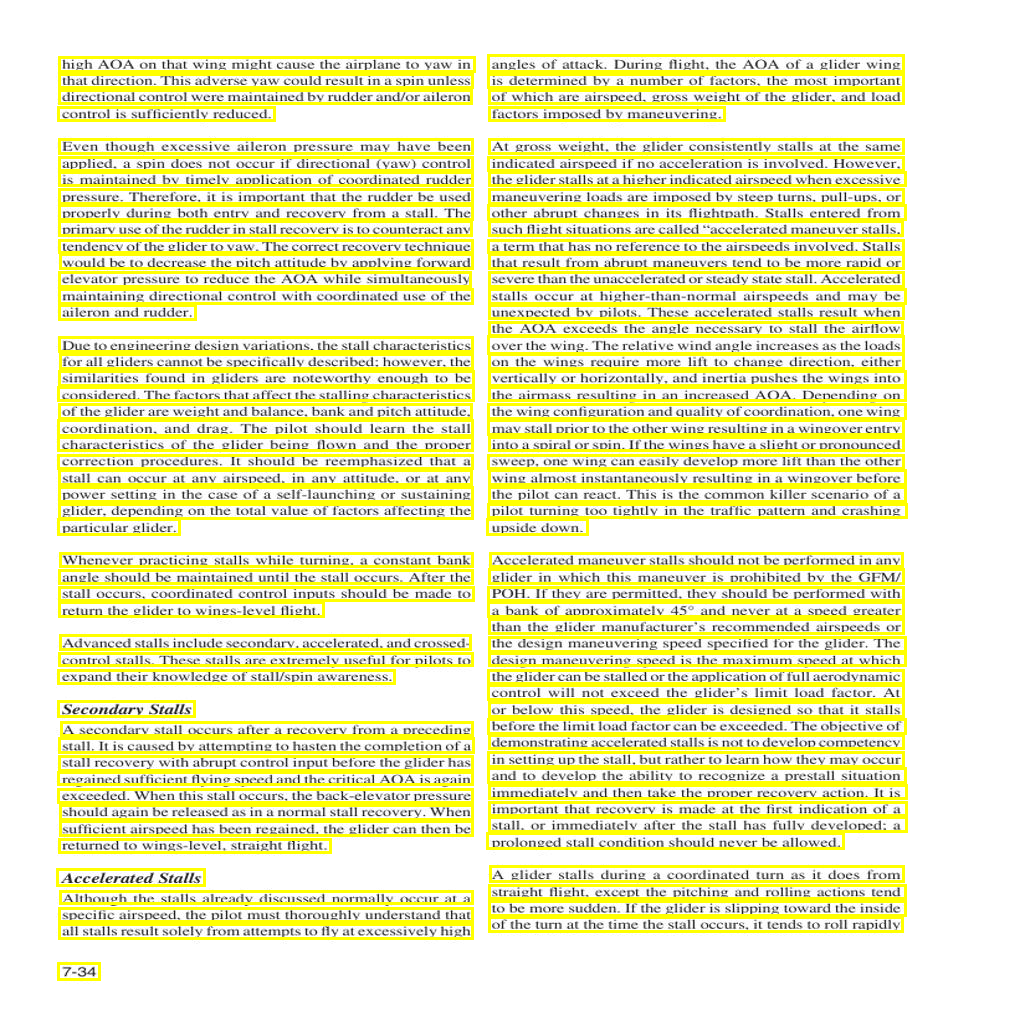

In [12]:
res.image_overlay

In [13]:
boxes=[]
for result in res.results:
    boxes.append(result["bbox"])
pysdk_boxes_arr = np.array(boxes)

### Compare the Openvino boxes and the PySDK boxes

In [15]:
openvino_boxes_arr == pysdk_boxes_arr
# np.allclose(openvino_boxes_arr, pysdk_boxes_arr)

False